### Setup

In [1]:
import numpy as np
from pathlib import Path
import sys

sys.path.append(str(Path.cwd().parent.parent))

from models.nli.common import METRICS_DIR, DATA_DIR

from evaluation.nli.helpers import (
    prepare_nli_tables,
    load_metric_files,
    create_table_b_styler,
    plot_calibration_comparison,
    run_cv_comparison,
    Q2QCalibration,
    IsotonicCalibration,
    load_train_test_data,
    to_model_score_data,
    plot_train_test_correlation_from_score_data,
)
from evaluation.core import (
    vis_specific_model_tables,
    vis_specific_model_conf_matrices,
    vis_all_models_plots,
    vis_all_models_tables,
)
from evaluation.nli.interface import nli_scores_to_core, get_nli_model_groups

### Tables

In [5]:
SELECTED_DIR = METRICS_DIR
files = sorted(SELECTED_DIR.glob("*.json"))
items = load_metric_files(files)

# Load train/test data for combined correlation computation
df_train, df_test = load_train_test_data(DATA_DIR)

# Clean, simple notebook code
df_a, latex_a, df_b, latex_b, bold_cols = prepare_nli_tables(items, df_train, df_test)

# Display Table A
display(
    df_a.style.format(
        precision=4, subset=[c for c in df_a.columns if c != "Rank"]
    ).hide(axis="index")
)
print(latex_a)

# Display Table B with all styling/highlighting built-in
styler = create_table_b_styler(df_b, bold_cols)
display(styler)
print(latex_b)

Rank,Hypothesis Template,Candidate Labels,Best Corr
1,"This text is {} in terms of visual details of characters, setting, or environment.","not detailed, detailed",0.8281
2,"This text is {} in terms of visual details of characters, setting, or environment.","not visual, visual",0.8103
3,"This text is {} in terms of visual details of characters, setting, or environment.","not descriptive, descriptive",0.8050
4,This text {}.,"lacks environmental context, establishes environment with visual elements",0.7633
5,This text includes {}.,"no scene description, scene with location and objects",0.7609
6,"This text is {} in terms of sensory details, imagery, characters, environment, and vivid descriptions.","not visual, visual",0.7235
7,This text provides {}.,"no spatial context, clear spatial context and arrangement",0.7214
8,This text {},"describes abstract concepts without visual imagery, describes a visually complete scene with setting and details",0.7189
9,"This text is {} in terms of sensory details, imagery, and vivid descriptions.","not visual, visual",0.7178
10,This text {}.,"does not describe appearance, describes physical appearance",0.7091


\begin{tabular}{lrrr}
\hline
 Rank & Hypothesis Template & Candidate Labels & Best Corr \\
\hline
 1 & This text is \\textbackslash{}{\\textbackslash{}} in terms of visual details of characters, setting, or environment. & not detailed, detailed & 0.8281 \\
 2 & This text is \\textbackslash{}{\\textbackslash{}} in terms of visual details of characters, setting, or environment. & not visual, visual & 0.8103 \\
 3 & This text is \\textbackslash{}{\\textbackslash{}} in terms of visual details of characters, setting, or environment. & not descriptive, descriptive & 0.8050 \\
 4 & This text \\textbackslash{}{\\textbackslash{}}. & lacks environmental context, establishes environment with visual elements & 0.7633 \\
 5 & This text includes \\textbackslash{}{\\textbackslash{}}. & no scene description, scene with location and objects & 0.7609 \\
 6 & This text is \\textbackslash{}{\\textbackslash{}} in terms of sensory details, imagery, characters, environment, and vivid descriptions. & not visu

Rank,RoBERTa Corr,ModernBERT-Large Corr,DeBERTaV3-Large Corr,RoBERTa Throughput,ModernBERT-Large Throughput,DeBERTaV3-Large Throughput
1,0.8281,0.7283,0.5091,38.8577,14.0542,13.1449
2,0.8103,0.7520,0.5574,35.6373,14.1359,13.2195
3,0.8050,0.7242,0.5264,35.3738,13.8785,13.7582
4,0.7633,0.6637,0.5850,38.2416,15.2377,14.2609
5,0.7609,0.6766,0.5860,38.4358,15.2067,13.8091
6,0.7235,0.7007,0.6349,34.2700,14.2967,12.9215
7,0.7214,0.5266,0.3888,38.9940,14.2753,14.1885
8,0.5279,0.7189,0.7042,39.0963,13.9224,13.2081
9,0.6683,0.7178,0.6379,34.7237,13.9180,12.5397
10,0.7091,0.4271,0.6603,36.9315,15.1877,13.7737


\begin{tabular}{lrrrrrr}
\hline
 Rank & RoBERTa Corr & ModernBERT-Large Corr & DeBERTaV3-Large Corr & RoBERTa Throughput & ModernBERT-Large Throughput & DeBERTaV3-Large Throughput \\
\hline
 1 & \textbf{0.8281} & 0.7283 & 0.5091 & 38.8577 & 14.0542 & 13.1449 \\
 2 & 0.8103 & \textbf{0.7520} & 0.5574 & 35.6373 & 14.1359 & 13.2195 \\
 3 & 0.8050 & 0.7242 & 0.5264 & 35.3738 & 13.8785 & 13.7582 \\
 4 & 0.7633 & 0.6637 & 0.5850 & 38.2416 & 15.2377 & 14.2609 \\
 5 & 0.7609 & 0.6766 & 0.5860 & 38.4358 & 15.2067 & 13.8091 \\
 6 & 0.7235 & 0.7007 & 0.6349 & 34.2700 & 14.2967 & 12.9215 \\
 7 & 0.7214 & 0.5266 & 0.3888 & 38.9940 & 14.2753 & 14.1885 \\
 8 & 0.5279 & 0.7189 & \textbf{0.7042} & 39.0963 & 13.9224 & 13.2081 \\
 9 & 0.6683 & 0.7178 & 0.6379 & 34.7237 & 13.9180 & 12.5397 \\
 10 & 0.7091 & 0.4271 & 0.6603 & 36.9315 & 15.1877 & 13.7737 \\
 11 & 0.7051 & 0.6869 & 0.6065 & 37.2435 & 14.3341 & 13.3990 \\
 12 & 0.7025 & 0.6730 & 0.6891 & 36.3998 & 14.9818 & 13.9357 \\
 13 & 0.5755 & 0.6782 & 

### Correlation Matrix


Using configuration 35 of 46


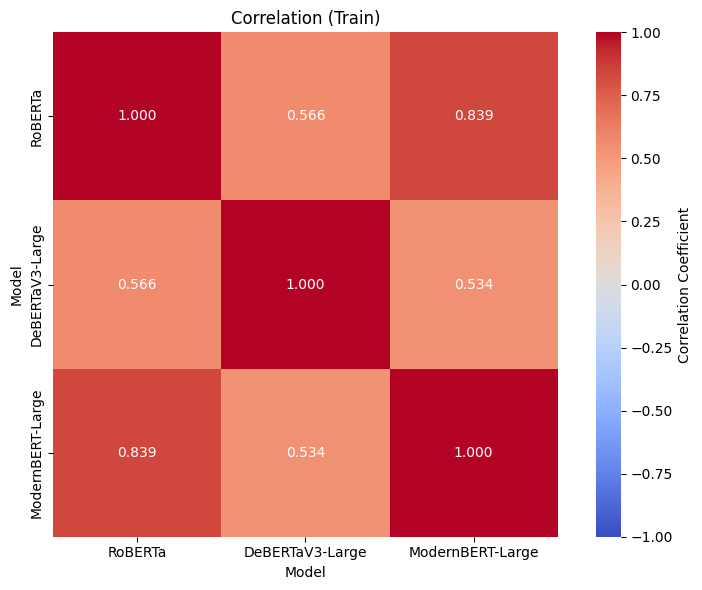

Correlation coefficients:
                   RoBERTa  DeBERTaV3-Large  ModernBERT-Large
RoBERTa           1.000000         0.565521          0.838816
DeBERTaV3-Large   0.565521         1.000000          0.534266
ModernBERT-Large  0.838816         0.534266          1.000000


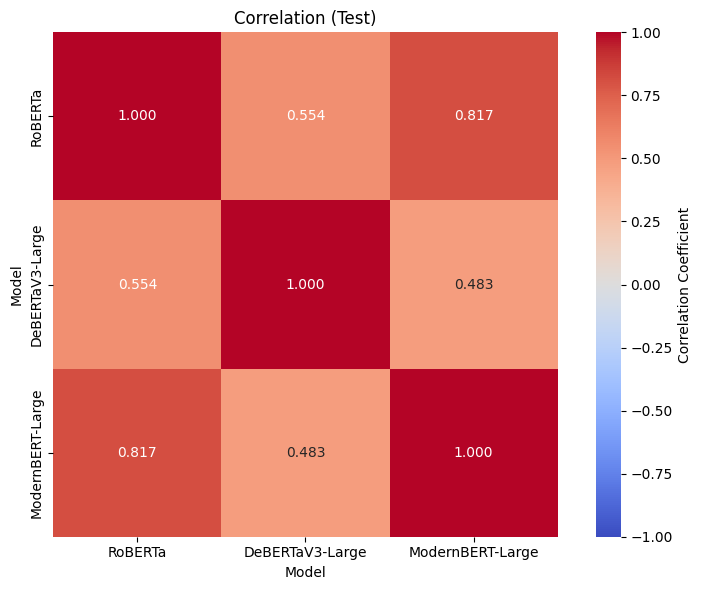

Correlation coefficients:
                   RoBERTa  DeBERTaV3-Large  ModernBERT-Large
RoBERTa           1.000000         0.553883          0.816976
DeBERTaV3-Large   0.553883         1.000000          0.482767
ModernBERT-Large  0.816976         0.482767          1.000000


In [27]:
CONFIG_IDX = 34
print(f"Using configuration {CONFIG_IDX + 1} of {len(items)}")

# Prepare train/test score data for the selected configuration
_df_train, _df_test = load_train_test_data(DATA_DIR)
_score_data = to_model_score_data(items, _df_train, _df_test)

# Plot two correlation matrices: Train and Test
plot_train_test_correlation_from_score_data(_score_data, CONFIG_IDX)

### Calibration Mapping


#### Cross-Validation Comparison: Isotonic vs Q2Q

In [11]:
SELECTED_DIR = METRICS_DIR
files = sorted(SELECTED_DIR.glob("*.json"))
items = load_metric_files(files)

df_train, df_test = load_train_test_data(DATA_DIR)
score_data = to_model_score_data(items, df_train, df_test)

sd = score_data[0] if score_data else None
if sd is None:
    raise RuntimeError("No score data available for CV comparison")

results_df = run_cv_comparison(sd.train_scores, sd.y_train)
print(results_df.to_string(index=False))

  Method  Mean RMSE  Std RMSE  Mean Accuracy  Std Accuracy
Isotonic   0.911326  0.065910       0.431321      0.037675
     Q2Q   1.001659  0.071671       0.476988      0.019297


#### Isotonic vs Q2Q visualization

Selected model: richardr1126/roberta-base-zeroshot-v2.0-c-ONNX
Train scores: (392,) values


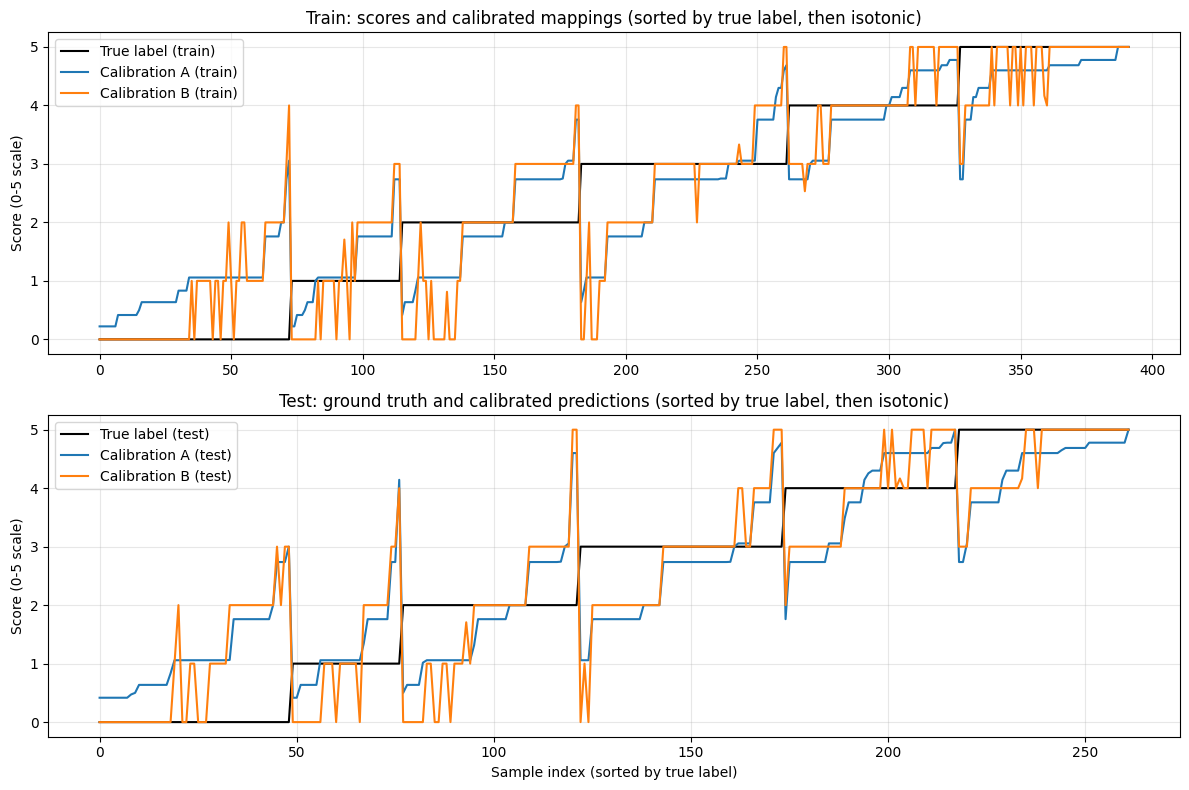

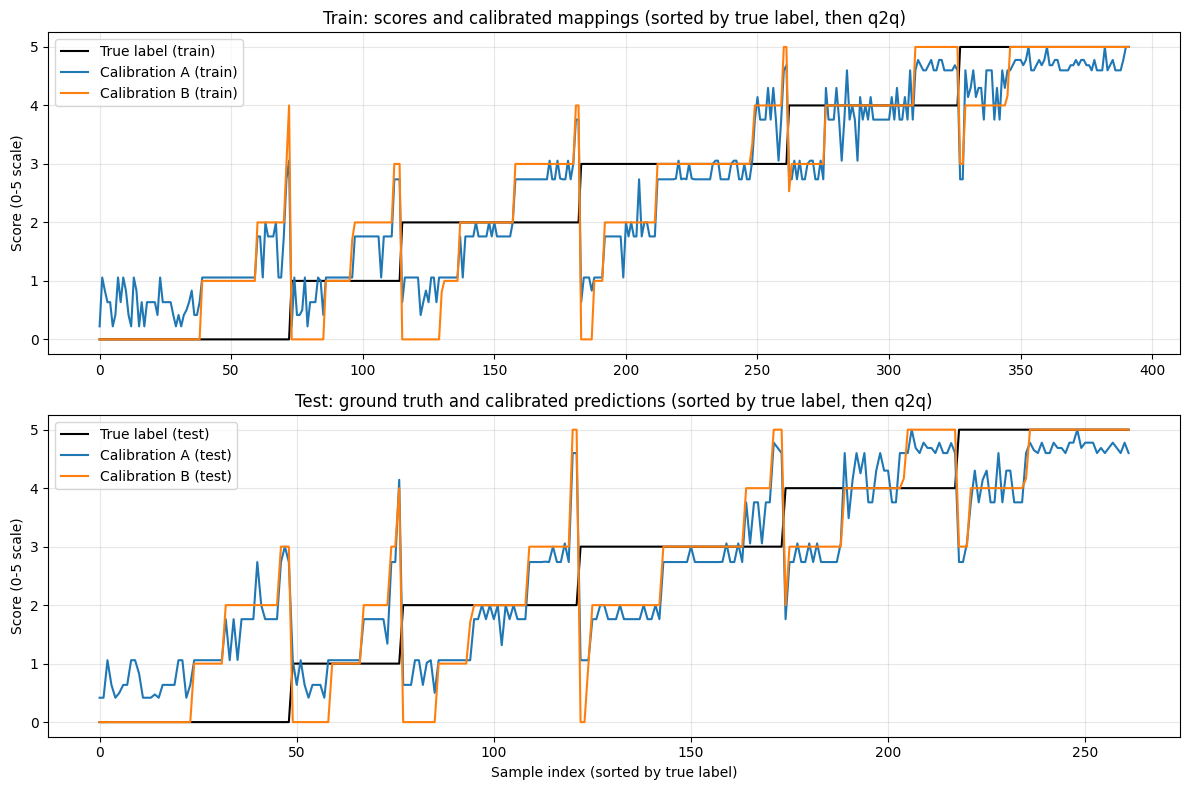

In [12]:
FILE_IDX = 0
MODEL_IDX = 0

# Ensure we have items loaded
files = sorted(METRICS_DIR.glob("*.json"))
items = load_metric_files(files)

df_train, df_test = load_train_test_data(DATA_DIR)
score_data = to_model_score_data(items, df_train, df_test)
sd = score_data[0] if score_data else None
if sd is None:
    raise RuntimeError("No score data available for calibration visualization")

print(f"Selected model: {sd.model_name}")
print(f"Train scores: {sd.train_scores.shape} values")

iso = IsotonicCalibration()
q2q = Q2QCalibration()

iso_cal = iso.fit(sd.train_scores, sd.y_train)
q2q_cal = q2q.fit(sd.train_scores, sd.y_train)

iso_train_pred = iso_cal.predict(sd.train_scores)
q2q_train_pred = q2q_cal.predict(sd.train_scores)

iso_test_pred = iso_cal.predict(sd.test_scores) if sd.test_scores is not None else None
q2q_test_pred = q2q_cal.predict(sd.test_scores) if sd.test_scores is not None else None


def _align_and_sort_local(scores, labels, a_pred, b_pred, sort_by_b=False):
    min_len = min(len(scores), len(labels), len(a_pred), len(b_pred))
    scores_aligned = scores[:min_len]
    labels_aligned = labels[:min_len]
    a_pred_aligned = a_pred[:min_len]
    b_pred_aligned = b_pred[:min_len]
    secondary = b_pred_aligned if sort_by_b else a_pred_aligned
    order = np.lexsort((secondary, labels_aligned))
    return (
        scores_aligned[order],
        labels_aligned[order],
        a_pred_aligned[order],
        b_pred_aligned[order],
    )


train_scores_sorted, y_train_sorted, iso_train_sorted, q2q_train_sorted = (
    _align_and_sort_local(
        sd.train_scores, sd.y_train, iso_train_pred, q2q_train_pred, sort_by_b=False
    )
)

if sd.y_test is not None and iso_test_pred is not None and q2q_test_pred is not None:
    _, y_test_sorted, iso_test_sorted, q2q_test_sorted = _align_and_sort_local(
        sd.test_scores, sd.y_test, iso_test_pred, q2q_test_pred, sort_by_b=False
    )
else:
    y_test_sorted = iso_test_sorted = q2q_test_sorted = None

plot_calibration_comparison(
    train_scores_sorted,
    y_train_sorted,
    iso_train_sorted,
    q2q_train_sorted,
    y_test_sorted,
    iso_test_sorted,
    q2q_test_sorted,
    title_suffix=" (sorted by true label, then isotonic)",
)

if sd.y_test is not None and iso_test_pred is not None and q2q_test_pred is not None:
    (
        train_scores_sorted_q2q,
        y_train_sorted_q2q,
        iso_train_sorted_q2q,
        q2q_train_sorted_q2q,
    ) = _align_and_sort_local(
        sd.train_scores, sd.y_train, iso_train_pred, q2q_train_pred, sort_by_b=True
    )
    _, y_test_sorted_q2q, iso_test_sorted_q2q, q2q_test_sorted_q2q = (
        _align_and_sort_local(
            sd.test_scores, sd.y_test, iso_test_pred, q2q_test_pred, sort_by_b=True
        )
    )

    plot_calibration_comparison(
        train_scores_sorted_q2q,
        y_train_sorted_q2q,
        iso_train_sorted_q2q,
        q2q_train_sorted_q2q,
        y_test_sorted_q2q,
        iso_test_sorted_q2q,
        q2q_test_sorted_q2q,
        title_suffix=" (sorted by true label, then q2q)",
    )

## Model Evaluation with Core Visualization

Convert NLI model scores to standardized evaluation format and visualize metrics.


### Load and Convert Model Scores


In [11]:
SELECTED_DIR = METRICS_DIR
files = sorted(SELECTED_DIR.glob("*.json"))
items = load_metric_files(files)

df_train, df_test = load_train_test_data(DATA_DIR)
score_data = to_model_score_data(items, df_train, df_test)

MODEL_TO_EVAL = 0
if score_data:
    sd = score_data[MODEL_TO_EVAL]
    aggregated_models = [
        nli_scores_to_core(
            sd.train_scores,
            sd.y_train,
            sd.test_scores,
            sd.y_test,
            model_name=sd.model_name,
        )
    ]
    print(f"Converted {len(aggregated_models)} model(s) for evaluation")
    print(f"Model: {aggregated_models[0].model}")
else:
    print("No score data available")
    aggregated_models = []

Converted 1 model(s) for evaluation
Model: richardr1126/roberta-base-zeroshot-v2.0-c-ONNX


### Configuration Selection

Select which configuration to evaluate. See available options below.

In [18]:
files = sorted(METRICS_DIR.glob("*.json"))
config_names = [f.stem for f in files]

print(f"Available configurations ({len(config_names)}):")
for idx, name in enumerate(config_names):
    print(f"  {idx}: {name}")

Available configurations (46):
  0: fttii_he_2025-12-23-15-53-16
  1: itttivitosdiavd_das_2025-12-23-16-04-17
  2: tcitti_ac_2025-12-23-15-09-00
  3: tcott_cc_2025-12-23-15-57-40
  4: tiitti_nsr_2025-12-23-16-10-42
  5: tilotti_nmlmhv_2025-12-23-16-35-30
  6: tlovditti_zmmgrf_2025-12-23-16-29-35
  7: tpd_nsodcf_2025-12-23-16-17-06
  8: tt_cc_2025-12-23-15-00-08
  9: tt_dd_2025-12-23-15-02-19
  10: tt_dd_2025-12-23-15-15-44
  11: tt_dd_2025-12-23-15-51-04
  12: tt_ic_2025-12-23-14-57-57
  13: tt_lc_2025-12-23-15-11-17
  14: tt_le_2025-12-23-15-39-56
  15: tt_li_2025-12-23-15-22-15
  16: tt_nc_2025-12-23-15-37-41
  17: tt_nd_2025-12-23-15-44-22
  18: tt_pp_2025-12-23-15-04-34
  19: ttd_ie_2025-12-23-15-26-39
  20: ttd_nv_2025-12-23-15-13-30
  21: ttd_so_2025-12-23-15-48-51
  22: ttdc_ac_2025-12-23-15-06-44
  23: ttdt_ww_2025-12-23-15-17-54
  24: tth_lh_2025-12-23-15-55-29
  25: tti_lr_2025-12-23-15-31-06
  26: tti_nc_2025-12-23-15-59-52
  27: tti_ns_2025-12-23-16-02-03
  28: tti_wi_2025-

In [19]:
SELECTED_CONFIG_IDX = 34
print(f"Selected configuration: {config_names[SELECTED_CONFIG_IDX]}")

Selected configuration: ttiitovdocsoe_nd_2025-12-23-14-39-35


### Specific Model Metrics Tables


In [33]:
filtered_score_data_specific = [
    sd for sd in score_data if sd.config_id == SELECTED_CONFIG_IDX
]
if filtered_score_data_specific:
    sd_specific = filtered_score_data_specific[0]
    specific_model = nli_scores_to_core(
        sd_specific.train_scores,
        sd_specific.y_train,
        sd_specific.test_scores,
        sd_specific.y_test,
        model_name=sd_specific.model_name,
        calibration_method=Q2QCalibration,
    )
    vis_specific_model_tables(specific_model)
else:
    print(f"No models found for configuration {SELECTED_CONFIG_IDX}")

TRAIN METRICS


,Label,Precision,Recall,F1,Support
0,0,0.5278,0.5205,0.5241,73
1,1,0.1905,0.1905,0.1905,42
2,2,0.3088,0.3088,0.3088,68
3,3,0.4500,0.4557,0.4528,79
4,4,0.4769,0.4769,0.4769,65
5,5,0.6923,0.6923,0.6923,65


Accuracy: 0.4566
MSE: 1.0487

CROSS-VALIDATION METRICS (Averaged Across Folds)


,Label,Precision,Recall,F1,Support
0,0,0.5395,0.5022,0.4961,14
1,1,0.2081,0.1811,0.1886,8
2,2,0.3100,0.3427,0.3052,13
3,3,0.4795,0.4751,0.4725,15
4,4,0.4569,0.4661,0.4591,13
5,5,0.7013,0.6851,0.6874,13


Accuracy: 0.4567
MSE: 1.0741

TEST METRICS


,Label,Precision,Recall,F1,Support
0,0,0.5349,0.4694,0.5000,49
1,1,0.1905,0.1429,0.1633,28
2,2,0.2759,0.3556,0.3107,45
3,3,0.4211,0.4615,0.4404,52
4,4,0.3571,0.3409,0.3488,44
5,5,0.5610,0.5227,0.5412,44


Accuracy: 0.4008
MSE: 1.1840

CROSS-VALIDATION METRICS - PER FOLD

--- Fold 1/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.3529,0.5000,0.4138,12
1,1,0.2857,0.2222,0.2500,9
2,2,0.2222,0.1111,0.1481,18
3,3,0.2632,0.3846,0.3125,13
4,4,0.6471,0.6471,0.6471,17
5,5,0.8000,0.8000,0.8000,10


Accuracy: 0.4304
MSE: 1.0153

--- Fold 2/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.6111,0.7333,0.6667,15
1,1,0.1000,0.1667,0.1250,6
2,2,0.4615,0.3333,0.3871,18
3,3,0.5333,0.4444,0.4848,18
4,4,0.4000,0.3333,0.3636,12
5,5,0.5385,0.7000,0.6087,10


Accuracy: 0.4684
MSE: 1.0127

--- Fold 3/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.7000,0.3889,0.5000,18
1,1,0.0000,0.0000,0.0000,5
2,2,0.2941,0.3846,0.3333,13
3,3,0.5294,0.5294,0.5294,17
4,4,0.5000,0.6000,0.5455,10
5,5,0.9091,0.6667,0.7692,15


Accuracy: 0.4744
MSE: 0.9703

--- Fold 4/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.7000,0.3889,0.5000,18
1,1,0.4545,0.4167,0.4348,12
2,2,0.1875,0.5000,0.2727,6
3,3,0.5455,0.4286,0.4800,14
4,4,0.4375,0.5000,0.4667,14
5,5,0.5714,0.5714,0.5714,14


Accuracy: 0.4615
MSE: 1.2564

--- Fold 5/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.3333,0.5000,0.4000,10
1,1,0.2000,0.1000,0.1333,10
2,2,0.3846,0.3846,0.3846,13
3,3,0.5263,0.5882,0.5556,17
4,4,0.3000,0.2500,0.2727,12
5,5,0.6875,0.6875,0.6875,16


Accuracy: 0.4487
MSE: 1.1157


### Confusion Matrices


TRAIN SET CONFUSION MATRIX


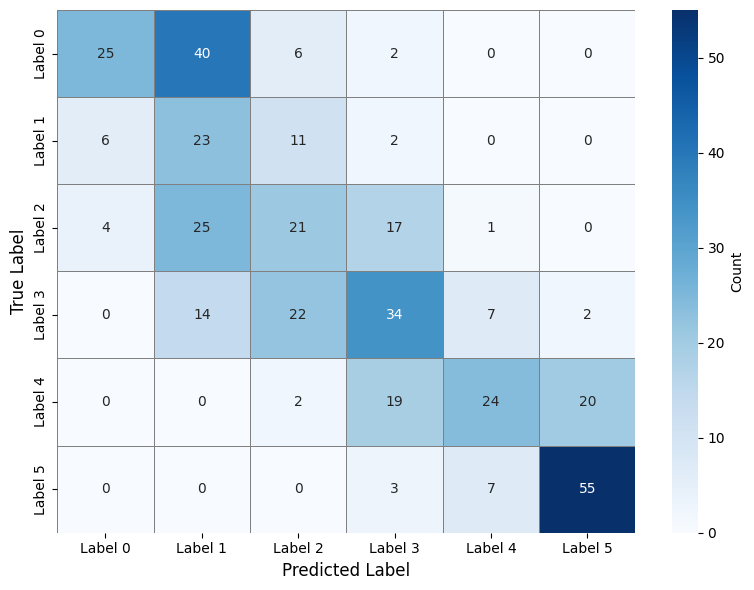


Confusion Matrix Statistics:
  Total predictions: 392
  Correct predictions (diagonal): 182
  Incorrect predictions (off-diagonal): 210
  Accuracy: 0.4643

Per-label statistics:
  Label 0: 25/73 correct (34.25%)
  Label 1: 23/42 correct (54.76%)
  Label 2: 21/68 correct (30.88%)
  Label 3: 34/79 correct (43.04%)
  Label 4: 24/65 correct (36.92%)
  Label 5: 55/65 correct (84.62%)

CROSS-VALIDATION CONFUSION MATRIX


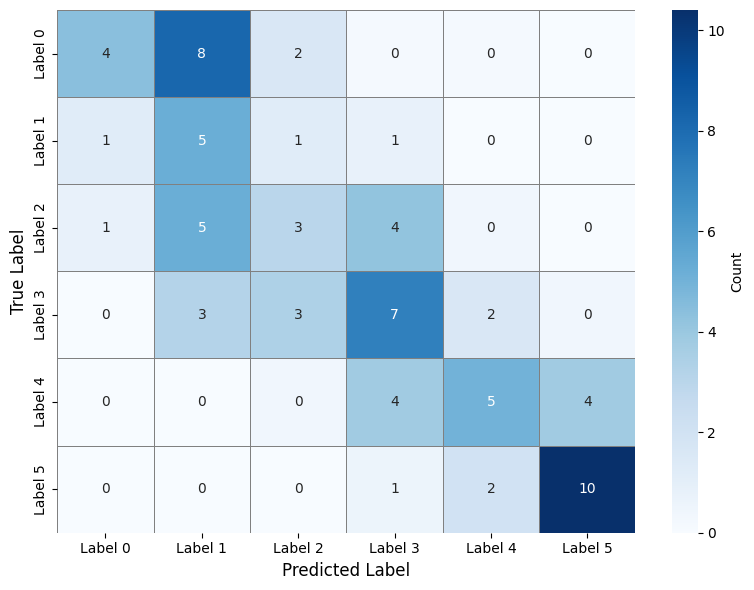


Confusion Matrix Statistics:
  Total predictions: 78.4
  Correct predictions (diagonal): 35.2
  Incorrect predictions (off-diagonal): 43.2
  Accuracy: 0.4490

Per-label statistics:
  Label 0: 4.4/14.599999999999998 correct (30.14%)
  Label 1: 5.2/8.4 correct (61.90%)
  Label 2: 3.0/13.6 correct (22.06%)
  Label 3: 7.2/15.8 correct (45.57%)
  Label 4: 5.0/13.0 correct (38.46%)
  Label 5: 10.4/13.0 correct (80.00%)

TEST SET CONFUSION MATRIX


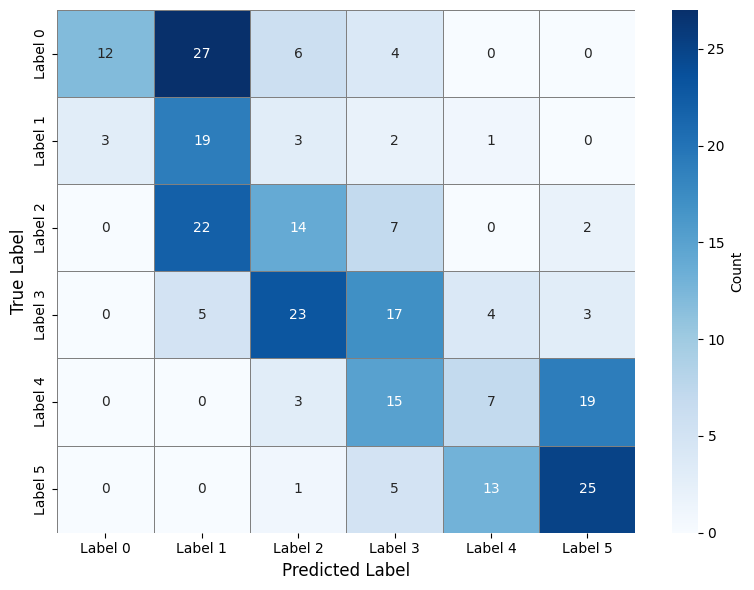


Confusion Matrix Statistics:
  Total predictions: 262
  Correct predictions (diagonal): 94
  Incorrect predictions (off-diagonal): 168
  Accuracy: 0.3588

Per-label statistics:
  Label 0: 12/49 correct (24.49%)
  Label 1: 19/28 correct (67.86%)
  Label 2: 14/45 correct (31.11%)
  Label 3: 17/52 correct (32.69%)
  Label 4: 7/44 correct (15.91%)
  Label 5: 25/44 correct (56.82%)


In [26]:
filtered_score_data_conf = [
    sd for sd in score_data if sd.config_id == SELECTED_CONFIG_IDX
]
if filtered_score_data_conf:
    sd_conf = filtered_score_data_conf[0]
    conf_model = nli_scores_to_core(
        sd_conf.train_scores,
        sd_conf.y_train,
        sd_conf.test_scores,
        sd_conf.y_test,
        model_name=sd_conf.model_name,
    )
    vis_specific_model_conf_matrices(
        conf_model, show_proportional=False, show_title=False
    )
else:
    print(f"No models found for configuration {SELECTED_CONFIG_IDX}")

### Multiple Models Comparison

Compare metrics across different NLI model configurations.


In [22]:
filtered_score_data = [sd for sd in score_data if sd.config_id == SELECTED_CONFIG_IDX]

multiple_models = []
for sd in filtered_score_data:
    converted = nli_scores_to_core(
        sd.train_scores,
        sd.y_train,
        sd.test_scores,
        sd.y_test,
        model_name=sd.model_name,
    )
    multiple_models.append(converted)

print(
    f"Loaded {len(multiple_models)} model(s) from configuration {SELECTED_CONFIG_IDX}: {config_names[SELECTED_CONFIG_IDX]}"
)
for m in multiple_models:
    print(f"  - {m.model}")

Loaded 3 model(s) from configuration 34: ttiitovdocsoe_nd_2025-12-23-14-39-35
  - richardr1126/roberta-base-zeroshot-v2.0-c-ONNX
  - richardr1126/deberta-v3-large-zeroshot-v2.0-ONNX
  - onnx-community/ModernBERT-large-zeroshot-v2.0-ONNX


#### Per-label metrics and model comparison plots


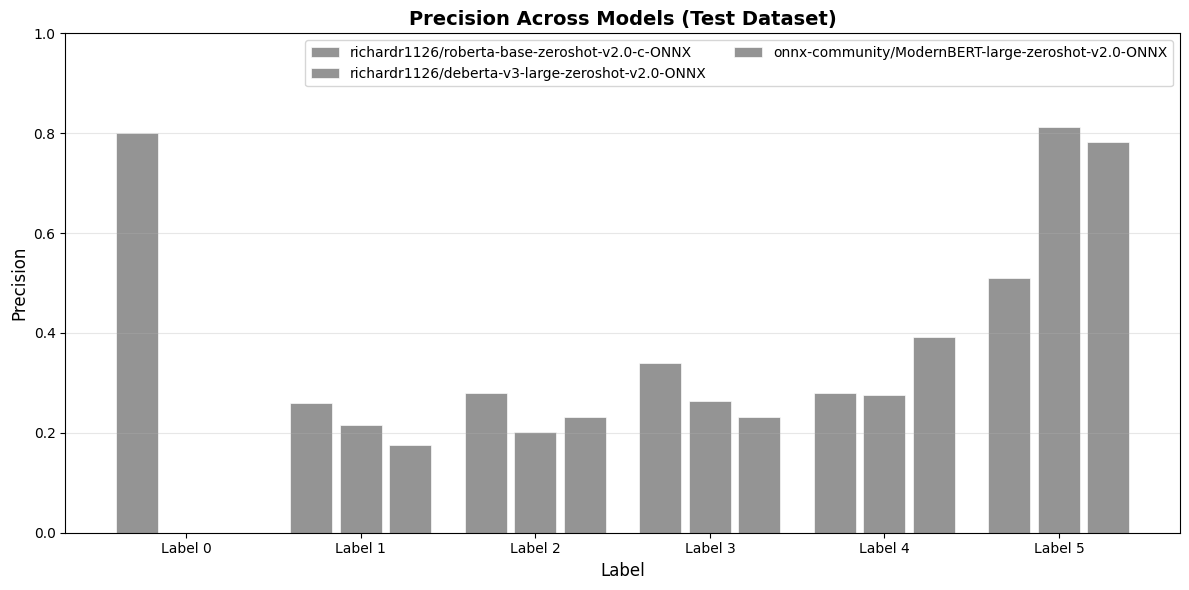

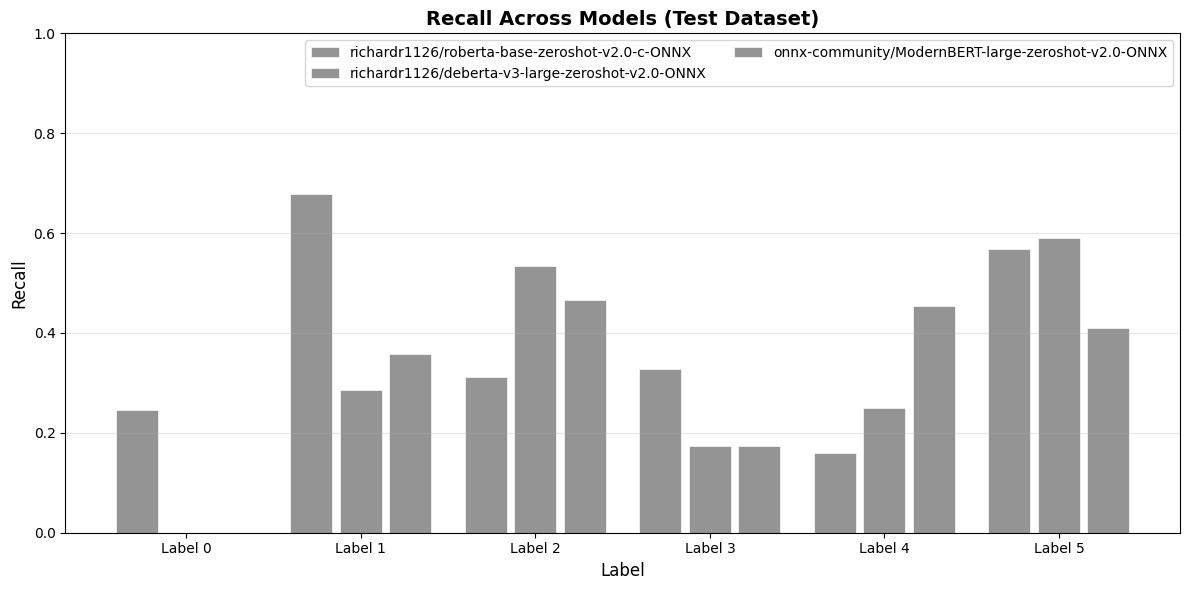

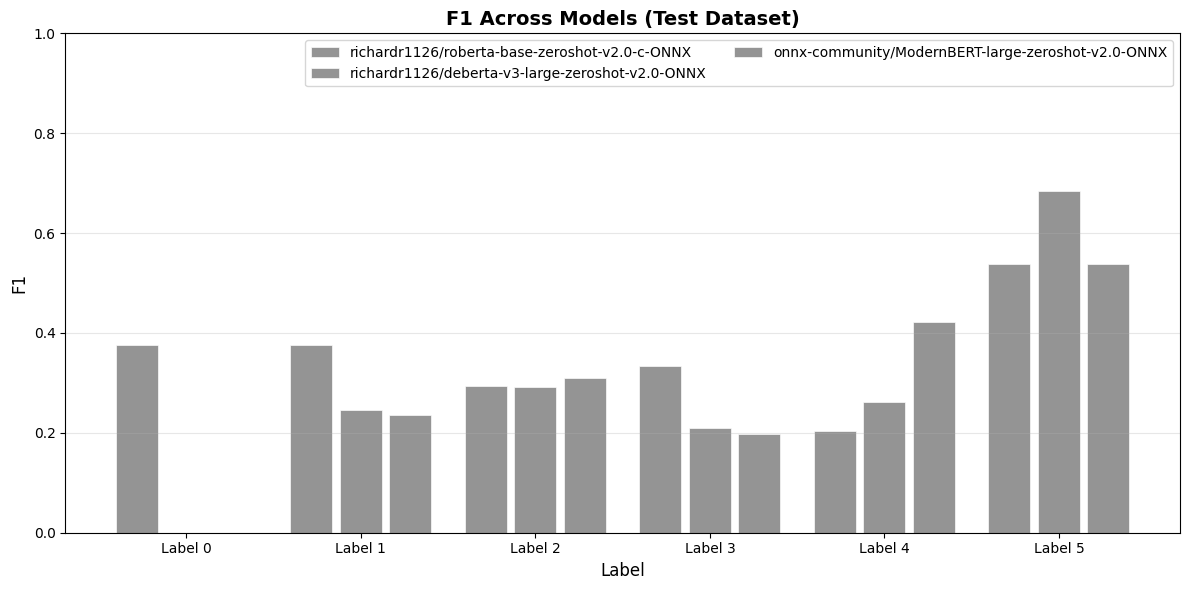

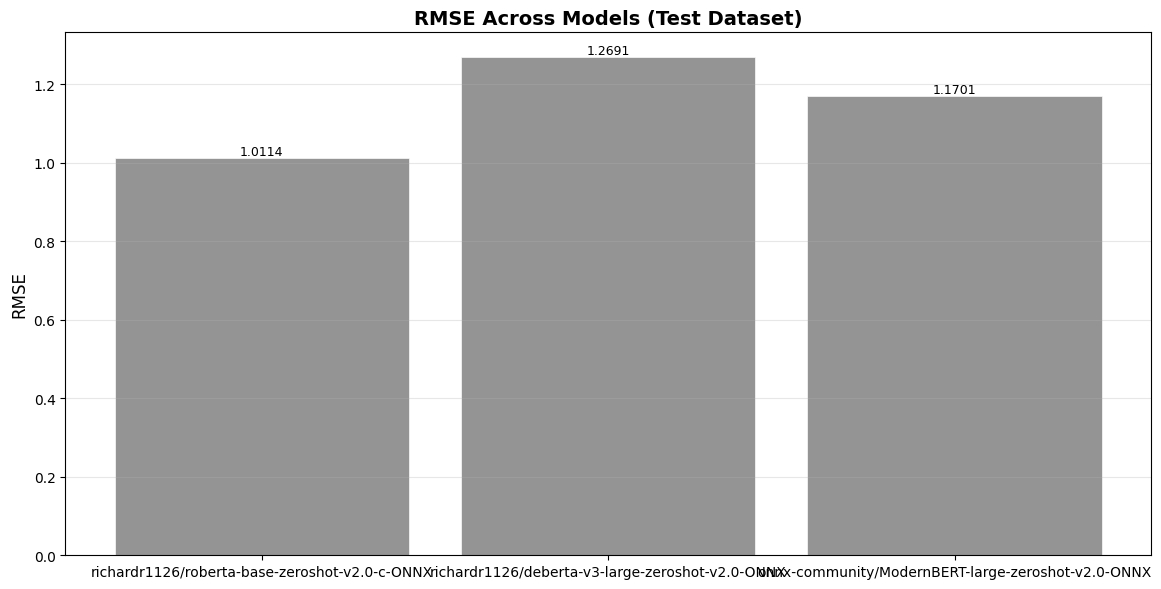

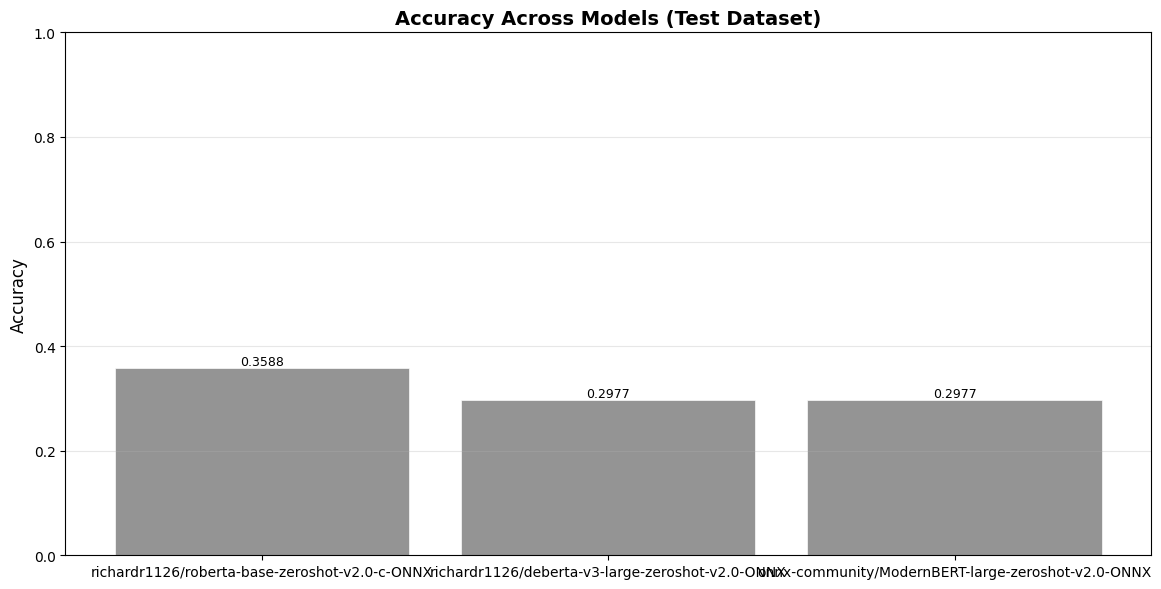

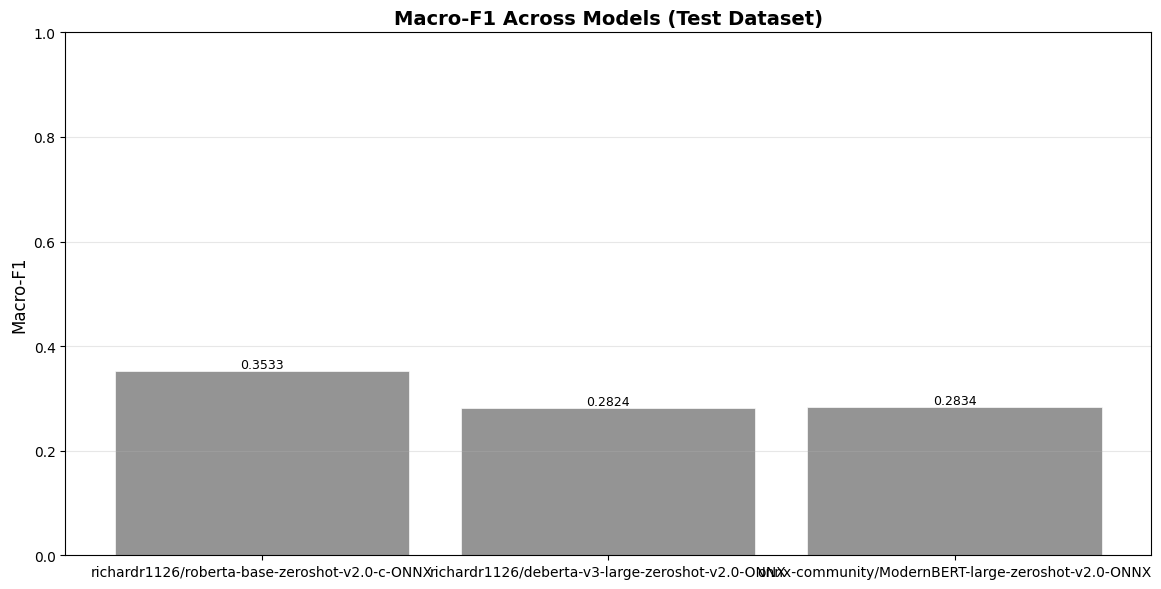

In [23]:
if multiple_models:
    vis_all_models_plots(multiple_models, "test")

#### Summary comparison table


In [24]:
if multiple_models:
    model_names = [m.model for m in multiple_models]
    model_groups, show_large_variants = get_nli_model_groups(model_names)
    df_metrics = vis_all_models_tables(
        multiple_models,
        ["RMSE", "Acc"],
        ["Train", "Val", "Test"],
        model_groups,
        show_large_variants,
    )

,Model,Train RMSE,Val RMSE,Test RMSE,Train Acc,Val Acc,Test Acc
0,richardr1126/roberta-base-zeroshot-v2.0-c-ONNX,0.8627,,1.0114,0.4643,,0.3588
1,richardr1126/deberta-v3-large-zeroshot-v2.0-ONNX,1.2012,,1.2691,0.3316,,0.2977
2,onnx-community/ModernBERT-large-zeroshot-v2.0-ONNX,1.1128,,1.1701,0.3316,,0.2977
